In [ ]:
from google.colab import drive
import os
import sys
import shutil
import subprocess

drive.mount('/content/drive')

# Project paths
PROJECT_PATH = '/content/drive/MyDrive/SVGEditor'
CODE_PATH = f"{PROJECT_PATH}/code"
MODEL_PATH = f"{PROJECT_PATH}/models"
OUTPUT_PATH = f"{PROJECT_PATH}/output"

if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)

# Target configuration
TARGET_NAME = "153_B"

# Input image path (from project resource folder)
INPUT_IMAGE = f"{CODE_PATH}/resource/{TARGET_NAME}.png"

# 模型配置 - 每个cell使用不同的模型
# 注意：TARGET_OUTPUT_PATH 将在每个cell中根据模型名称动态生成

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install dependencies
%pip install diffusers accelerate safetensors transformers huggingface_hub segment-anything opencv-python pillow matplotlib scikit-image scikit-learn cairosvg moviepy shapely networkx lxml skan rdp

import shutil
import subprocess

# Clean and clone repository
if os.path.exists(CODE_PATH):
    shutil.rmtree(CODE_PATH)

os.chdir(PROJECT_PATH)
result = subprocess.run(['git', 'clone', 'https://github.com/huanbasara/SVGEditor.git', 'code'],
                       capture_output=True, text=True)
print(f"Repository {'successfully' if result.returncode == 0 else 'failed'} cloned")

# Display latest commit info
os.chdir(CODE_PATH)
commit_info = subprocess.run(['git', 'log', '-1', '--pretty=format:%ci|%s'],
                           capture_output=True, text=True)

if commit_info.returncode == 0:
    commit_time, commit_msg = commit_info.stdout.strip().split('|', 1)
    print(f"Latest commit: {commit_time.split()[0]} - {commit_msg}")

# Add to Python path and reload modules
if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)

# Clear custom modules from cache
for base in ['sam_processor', 'svglib', 'utils']:
    to_remove = [m for m in sys.modules if m.startswith(base)]
    for m in to_remove:
        del sys.modules[m]

# Create necessary directories
os.makedirs(OUTPUT_PATH, exist_ok=True)

print("Setup complete!")

Code repository successfully cloned
Latest commit: ec6be08 (2025-10-02) - optimize smooth_open 1
Modules reloaded!


In [ ]:
# ==================== Cell 2: SD1.5 + IP-Adapter ====================

import torch
import gc
import time
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image
from utils.prompt_utils import get_prompt, get_negative_prompt
from utils.plot_utils import plot_images

# 模型配置
MODEL_NAME = "sd15_ip_adapter"
TARGET_OUTPUT_PATH = f"{OUTPUT_PATH}/{MODEL_NAME}/{TARGET_NAME}"
os.makedirs(TARGET_OUTPUT_PATH, exist_ok=True)

# IP-Adapter 参数组合配置
PARAM_COMBINATIONS = [
    {"strength": 0.3, "guidance_scale": 7.0, "ip_adapter_scale": 0.8},
    {"strength": 0.5, "guidance_scale": 10.0, "ip_adapter_scale": 0.3},
    {"strength": 0.6, "guidance_scale": 12.0, "ip_adapter_scale": 0.2},
    {"strength": 0.4, "guidance_scale": 8.0, "ip_adapter_scale": 0.5},
    {"strength": 0.2, "guidance_scale": 6.0, "ip_adapter_scale": 0.9},
]

def load_sd15_ip_adapter_model():
    """Load SD1.5+IP-Adapter model"""
    start_time = time.time()

    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        f"{MODEL_PATH}/stable-diffusion-v1-5",
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False,
        low_cpu_mem_usage=True
    ).to("cuda")

    pipe.load_ip_adapter(
        f"{MODEL_PATH}/ip-adapter",
        subfolder="models",
        weight_name="ip-adapter_sd15.bin"
    )

    pipe.enable_vae_slicing()
    pipe.enable_model_cpu_offload()

    load_time = time.time() - start_time
    print(f"Model loaded successfully, time: {load_time:.2f}s")
    return pipe

def process_with_ip_adapter(pipe, param_index, params):
    """Process image with IP-Adapter"""
    start_time = time.time()

    # Load and resize image
    original_image = Image.open(INPUT_IMAGE)
    pil_image_256 = original_image.resize((256, 256), Image.Resampling.LANCZOS)
    style_reference = pil_image_256

    # Get prompt
    full_prompt = get_prompt(TARGET_NAME)
    negative_prompt = get_negative_prompt()

    # IP-Adapter inference
    result = pipe(
        prompt=full_prompt,
        negative_prompt=negative_prompt,
        image=pil_image_256,
        ip_adapter_image=style_reference,
        strength=params['strength'],
        guidance_scale=params['guidance_scale'],
        ip_adapter_scale=params['ip_adapter_scale'],
        num_inference_steps=25,
        height=256,
        width=256,
        num_images_per_prompt=1,
        generator=torch.Generator().manual_seed(42)
    ).images[0]

    # Save result
    result_path = f"{TARGET_OUTPUT_PATH}/{TARGET_NAME}_param{param_index}.png"
    result.save(result_path)

    # Display comparison using plot_utils
    param_text = f"Parameters: S={params['strength']}, G={params['guidance_scale']}, IP={params['ip_adapter_scale']}"
    plot_images([
        (pil_image_256, "Original"),
        (style_reference, "Style Reference"),
        (result, f"SD1.5+IP-Adapter - Param {param_index}")
    ], bottom_text=param_text)

    inference_time = time.time() - start_time
    print(f"Parameter set {param_index} completed, time: {inference_time:.2f}s")

    return result

# Execute SD1.5+IP-Adapter experiment
print(f"SD1.5 + IP-Adapter Experiment - Target: {TARGET_NAME}")

# Load model
pipe = load_sd15_ip_adapter_model()

# Test all parameter combinations
results = []
for param_idx, params in enumerate(PARAM_COMBINATIONS):
    result = process_with_ip_adapter(pipe, param_idx, params)
    results.append(result)

print(f"Experiment completed, generated {len(results)} results")

# Clean up model
del pipe
torch.cuda.empty_cache()
gc.collect()


Output hidden; open in https://colab.research.google.com to view.

InstructPix2Pix Experiment - Target: 153_B


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (107 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['all lines are clear , smooth , and of the same color depth and weight . avoid any variations in line weight or opacity within the new image .']


Model loaded successfully, time: 128.98s


  0%|          | 0/30 [00:00<?, ?it/s]

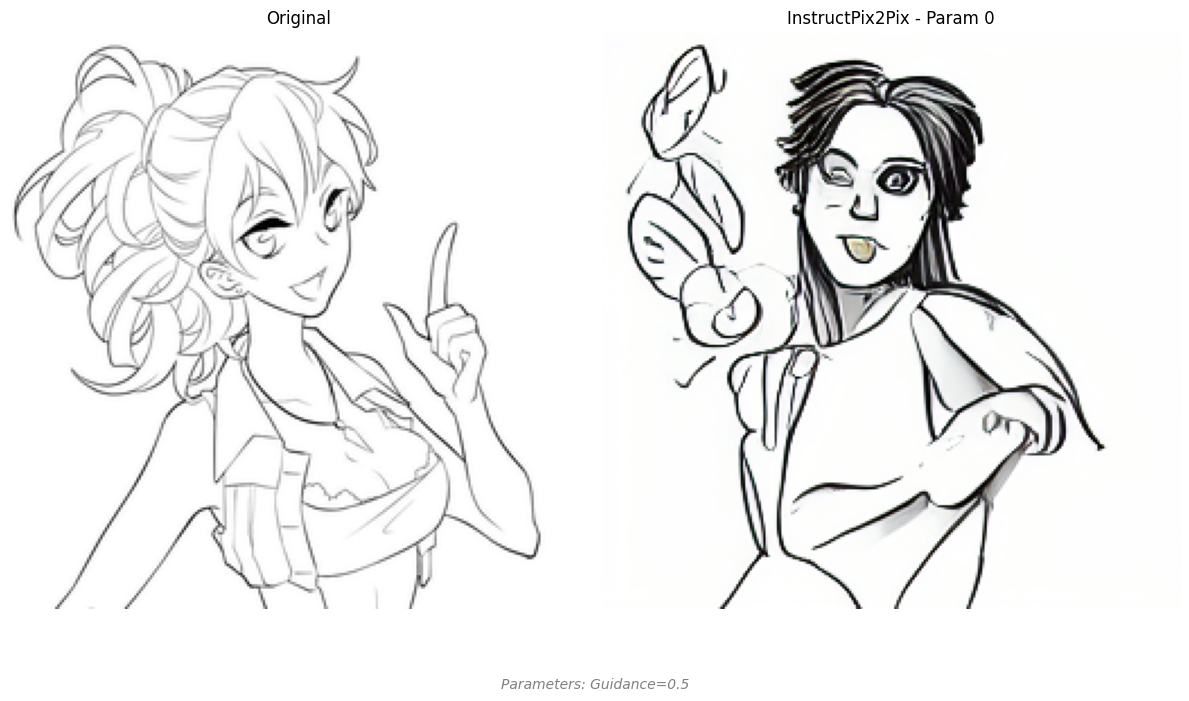

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['all lines are clear , smooth , and of the same color depth and weight . avoid any variations in line weight or opacity within the new image .']


Parameter set 0 completed, time: 1.86s


  0%|          | 0/30 [00:00<?, ?it/s]

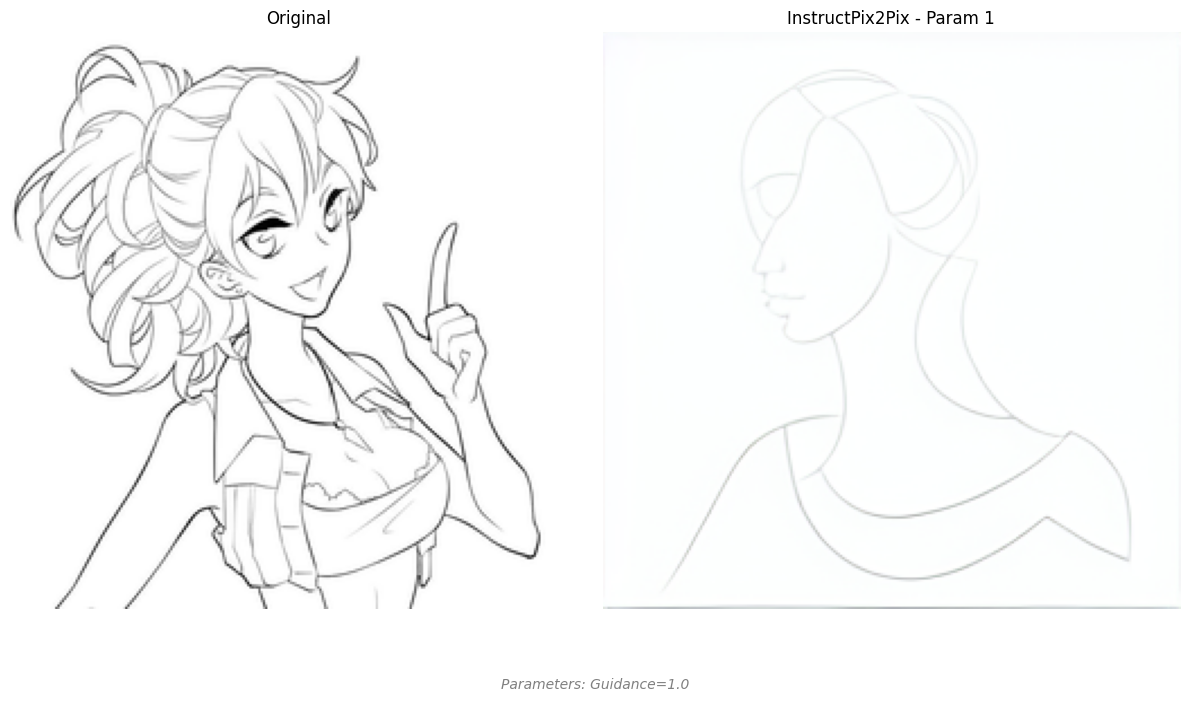

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['all lines are clear , smooth , and of the same color depth and weight . avoid any variations in line weight or opacity within the new image .']


Parameter set 1 completed, time: 1.74s


  0%|          | 0/30 [00:00<?, ?it/s]

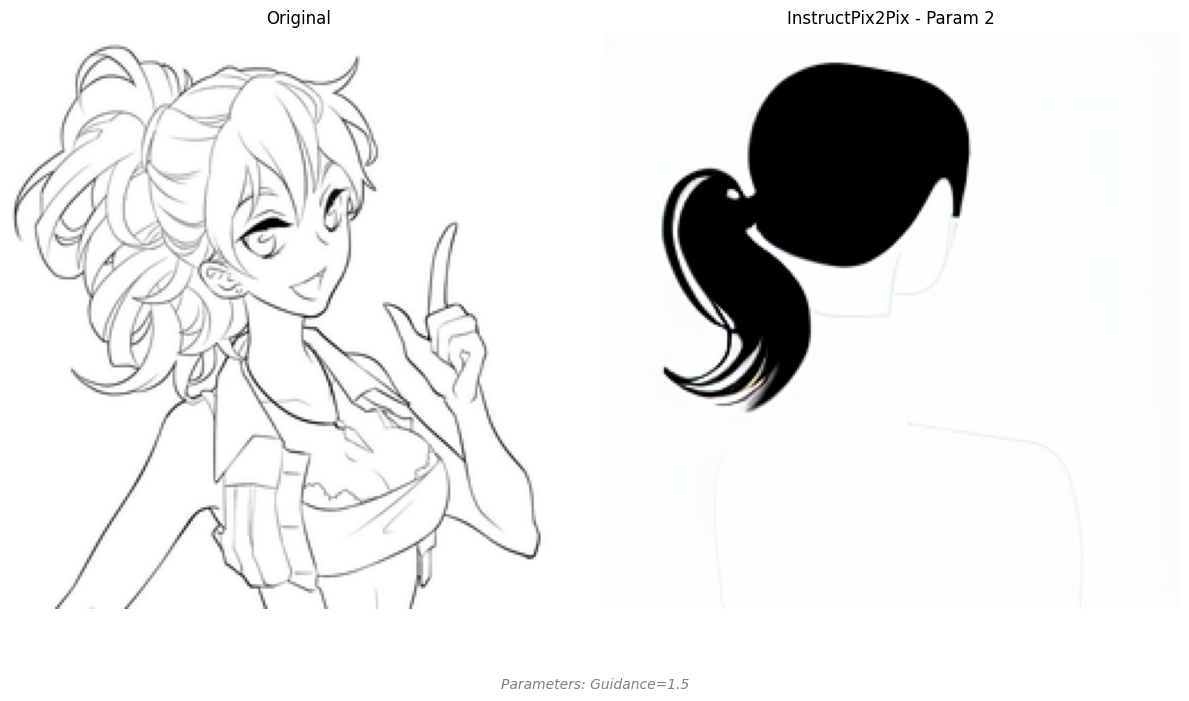

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['all lines are clear , smooth , and of the same color depth and weight . avoid any variations in line weight or opacity within the new image .']


Parameter set 2 completed, time: 1.63s


  0%|          | 0/30 [00:00<?, ?it/s]

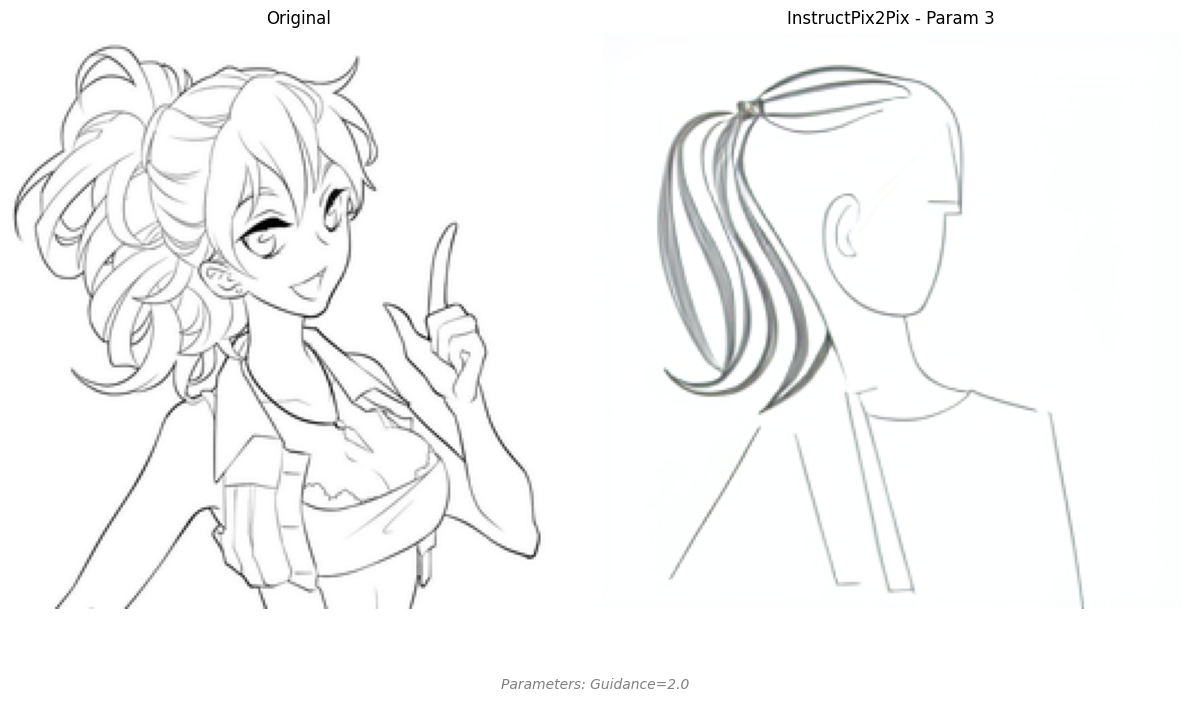

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['all lines are clear , smooth , and of the same color depth and weight . avoid any variations in line weight or opacity within the new image .']


Parameter set 3 completed, time: 1.59s


  0%|          | 0/30 [00:00<?, ?it/s]

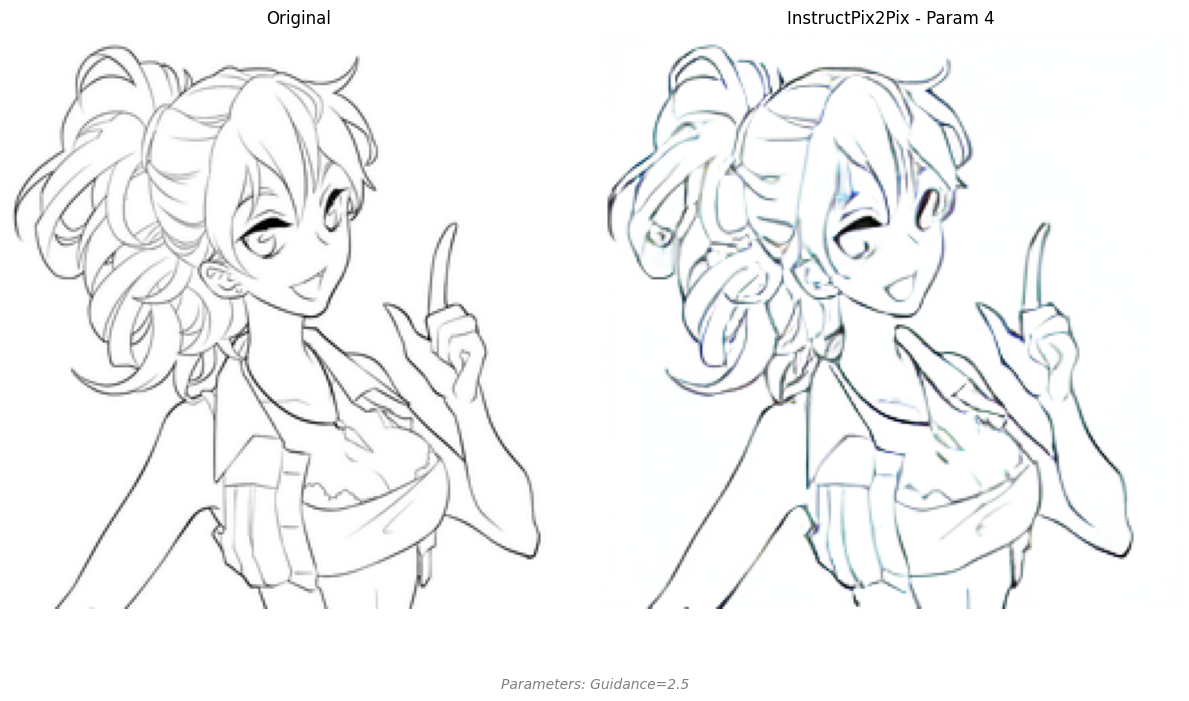

Parameter set 4 completed, time: 1.64s
Experiment completed, generated 5 results


17566

In [ ]:
# ==================== Cell 3: InstructPix2Pix ====================

import torch
import gc
import time
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
from PIL import Image
from utils.prompt_utils import get_prompt, get_negative_prompt
from utils.plot_utils import plot_images

# Model configuration
MODEL_NAME = "instruct_pix2pix"
TARGET_OUTPUT_PATH = f"{OUTPUT_PATH}/{MODEL_NAME}/{TARGET_NAME}"
os.makedirs(TARGET_OUTPUT_PATH, exist_ok=True)

# InstructPix2Pix parameter combinations
PARAM_COMBINATIONS = [
    {"image_guidance_scale": 0.5},
    {"image_guidance_scale": 1.0},
    {"image_guidance_scale": 1.5},
    {"image_guidance_scale": 2.0},
    {"image_guidance_scale": 2.5},
]

def load_instruct_pix2pix_model():
    """Load InstructPix2Pix model"""
    start_time = time.time()

    pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
        f"{MODEL_PATH}/instruct-pix2pix",
        torch_dtype=torch.float16,
        safety_checker=None
    )
    pipe.to("cuda")
    pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

    load_time = time.time() - start_time
    print(f"Model loaded successfully, time: {load_time:.2f}s")
    return pipe

def process_with_instruct_pix2pix(pipe, param_index, params):
    """Process image with InstructPix2Pix"""
    start_time = time.time()

    # Load and resize image
    original_image = Image.open(INPUT_IMAGE)
    pil_image_256 = original_image.resize((256, 256), Image.Resampling.LANCZOS)

    # Get prompt
    full_prompt = get_prompt(TARGET_NAME)

    # InstructPix2Pix inference
    result = pipe(
        prompt=full_prompt,
        image=pil_image_256,
        num_inference_steps=30,
        image_guidance_scale=params['image_guidance_scale']
    ).images[0]

    # Save result
    result_path = f"{TARGET_OUTPUT_PATH}/{TARGET_NAME}_param{param_index}.png"
    result.save(result_path)

    # Display comparison using plot_utils
    param_text = f"Parameters: Image Guidance={params['image_guidance_scale']}"
    plot_images([
        (pil_image_256, "Original"),
        (result, f"InstructPix2Pix - Param {param_index}")
    ], bottom_text=param_text)

    inference_time = time.time() - start_time
    print(f"Parameter set {param_index} completed, time: {inference_time:.2f}s")

    return result

# Execute InstructPix2Pix experiment
print(f"InstructPix2Pix Experiment - Target: {TARGET_NAME}")

# Load model
pipe = load_instruct_pix2pix_model()

# Test all parameter combinations
results = []
for param_idx, params in enumerate(PARAM_COMBINATIONS):
    result = process_with_instruct_pix2pix(pipe, param_idx, params)
    results.append(result)

print(f"Experiment completed, generated {len(results)} results")

# Clean up model
del pipe
torch.cuda.empty_cache()
gc.collect()


In [23]:
# ==================== Cell 4: AAM XL AnimeMix ====================

import torch
import gc
import time
from diffusers import StableDiffusionXLPipeline, DEISMultistepScheduler
from PIL import Image
from utils.prompt_utils import get_prompt, get_negative_prompt
from utils.plot_utils import plot_images

# Model configuration
MODEL_NAME = "aam_xl_animemix"
TARGET_OUTPUT_PATH = f"{OUTPUT_PATH}/{MODEL_NAME}/{TARGET_NAME}"
os.makedirs(TARGET_OUTPUT_PATH, exist_ok=True)

# AAM XL AnimeMix parameter combinations
PARAM_COMBINATIONS = [
    {"guidance_scale": 6.0},
    {"guidance_scale": 7.5},
    {"guidance_scale": 9.0},
    {"guidance_scale": 10.5},
    {"guidance_scale": 12.0},
]

def load_aam_xl_animemix_model():
    """Load AAM XL AnimeMix model from safetensors checkpoint"""
    start_time = time.time()

    # Load from safetensors checkpoint file
    checkpoint_path = f"{MODEL_PATH}/aamXLAnimeMix/aamXLAnimeMix_v10.safetensors"
    pipe = StableDiffusionXLPipeline.from_single_file(
        checkpoint_path,
        torch_dtype=torch.float16
    )
    pipe.scheduler = DEISMultistepScheduler.from_config(pipe.scheduler.config)
    pipe = pipe.to("cuda")

    load_time = time.time() - start_time
    print(f"Model loaded successfully, time: {load_time:.2f}s")
    return pipe

def process_with_aam_xl_animemix(pipe, param_index, params):
    """Process with AAM XL AnimeMix"""
    start_time = time.time()

    # Load and resize original image for comparison
    original_image = Image.open(INPUT_IMAGE)
    pil_image_256 = original_image.resize((256, 256), Image.Resampling.LANCZOS)

    # Get prompt - this model generates from text only
    full_prompt = get_prompt(TARGET_NAME)

    # AAM XL AnimeMix inference
    generator = torch.Generator().manual_seed(42)
    result = pipe(
        prompt=full_prompt,
        num_inference_steps=30,
        guidance_scale=params['guidance_scale'],
        generator=generator
    ).images[0]

    # Resize to match other models for comparison
    result = result.resize((256, 256), Image.Resampling.LANCZOS)

    # Save result
    result_path = f"{TARGET_OUTPUT_PATH}/{TARGET_NAME}_param{param_index}.png"
    result.save(result_path)

    # Display comparison using plot_utils
    param_text = f"Parameters: Guidance={params['guidance_scale']}"
    plot_images([
        (pil_image_256, "Original"),
        (result, f"AAM XL AnimeMix - Param {param_index}")
    ], bottom_text=param_text)

    inference_time = time.time() - start_time
    print(f"Parameter set {param_index} completed, time: {inference_time:.2f}s")

    return result

# Execute AAM XL AnimeMix experiment
print(f"AAM XL AnimeMix Experiment - Target: {TARGET_NAME}")

# Load model
pipe = load_aam_xl_animemix_model()

# Test all parameter combinations
results = []
for param_idx, params in enumerate(PARAM_COMBINATIONS):
    result = process_with_aam_xl_animemix(pipe, param_idx, params)
    results.append(result)

print(f"Experiment completed, generated {len(results)} results")

# Clean up model
del pipe
torch.cuda.empty_cache()
gc.collect()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# ==================== Cell 6: InstructPix2Pix SDXL ====================

import torch
import gc
import time
from diffusers import StableDiffusionXLInstructPix2PixPipeline, DEISMultistepScheduler
from PIL import Image
from utils.prompt_utils import get_prompt, get_negative_prompt
from utils.plot_utils import plot_images

# Model configuration
MODEL_NAME = "instruct_pix2pix_sdxl"
TARGET_OUTPUT_PATH = f"{OUTPUT_PATH}/{MODEL_NAME}/{TARGET_NAME}"
os.makedirs(TARGET_OUTPUT_PATH, exist_ok=True)

# InstructPix2Pix SDXL parameter combinations
PARAM_COMBINATIONS = [
    {"guidance_scale": 3.0, "image_guidance_scale": 0.5},
    {"guidance_scale": 3.0, "image_guidance_scale": 1.0},
    {"guidance_scale": 3.0, "image_guidance_scale": 1.5},
    {"guidance_scale": 3.0, "image_guidance_scale": 2.0},
    {"guidance_scale": 3.0, "image_guidance_scale": 2.5},
]

def load_instruct_pix2pix_sdxl_model():
    """Load InstructPix2Pix SDXL model"""
    start_time = time.time()

    pipe = StableDiffusionXLInstructPix2PixPipeline.from_pretrained(
        f"{MODEL_PATH}/instruct-pix2pix-sdxl",
        torch_dtype=torch.float16
    ).to("cuda")

    load_time = time.time() - start_time
    print(f"Model loaded successfully, time: {load_time:.2f}s")
    return pipe

def process_with_instruct_pix2pix_sdxl(pipe, param_index, params):
    """Process with InstructPix2Pix SDXL"""
    start_time = time.time()

    # Load and resize original image for comparison
    original_image = Image.open(INPUT_IMAGE)
    pil_image_256 = original_image.resize((256, 256), Image.Resampling.LANCZOS)

    # Get prompt
    full_prompt = get_prompt(TARGET_NAME)

    # InstructPix2Pix SDXL inference
    generator = torch.Generator().manual_seed(42)
    result = pipe(
        prompt=full_prompt,
        image=pil_image_256,
        height=256,
        width=256,
        guidance_scale=params['guidance_scale'],
        image_guidance_scale=params['image_guidance_scale'],
        num_inference_steps=30,
        generator=generator
    ).images[0]

    # Resize to match other models for comparison
    result = result.resize((256, 256), Image.Resampling.LANCZOS)

    # Save result
    result_path = f"{TARGET_OUTPUT_PATH}/{TARGET_NAME}_param{param_index}.png"
    result.save(result_path)

    # Display comparison using plot_utils
    param_text = f"Parameters: Guidance={params['guidance_scale']}, Image Guidance={params['image_guidance_scale']}"
    plot_images([
        (pil_image_256, "Original"),
        (result, f"InstructPix2Pix SDXL - Param {param_index}")
    ], bottom_text=param_text)

    inference_time = time.time() - start_time
    print(f"Parameter set {param_index} completed, time: {inference_time:.2f}s")

    return result

# Execute InstructPix2Pix SDXL experiment
print(f"InstructPix2Pix SDXL Experiment - Target: {TARGET_NAME}")

# Load model
pipe = load_instruct_pix2pix_sdxl_model()

# Test all parameter combinations
results = []
for param_idx, params in enumerate(PARAM_COMBINATIONS):
    result = process_with_instruct_pix2pix_sdxl(pipe, param_idx, params)
    results.append(result)

print(f"Experiment completed, generated {len(results)} results")

# Clean up model
del pipe
torch.cuda.empty_cache()
gc.collect()


In [ ]:
# ==================== SDXL Base + Img2Img ====================

import torch
import gc
import time
from diffusers import StableDiffusionXLImg2ImgPipeline, DEISMultistepScheduler
from PIL import Image
from utils.prompt_utils import get_prompt, get_negative_prompt
from utils.plot_utils import plot_images

# Model configuration
MODEL_NAME = "sdxl_base_img2img"
TARGET_OUTPUT_PATH = f"{OUTPUT_PATH}/{MODEL_NAME}/{TARGET_NAME}"
os.makedirs(TARGET_OUTPUT_PATH, exist_ok=True)

# SDXL Base + Img2Img parameter combinations
PARAM_COMBINATIONS = [
    {"strength": 0.3, "guidance_scale": 7.0},
    {"strength": 0.5, "guidance_scale": 10.0},
    {"strength": 0.6, "guidance_scale": 12.0},
    {"strength": 0.4, "guidance_scale": 8.0},
    {"strength": 0.2, "guidance_scale": 6.0},
]

def load_sdxl_base_img2img_model():
    """Load SDXL Base + Img2Img model"""
    start_time = time.time()

    try:
        pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
            f"{MODEL_PATH}/stable-diffusion-xl-base",
            torch_dtype=torch.float16,
            use_safetensors=True
        )
        print("✅ Loaded SDXL from local")
    except Exception as e:
        print(f"⚠️ Local SDXL incomplete: {e}")
        print("Falling back to Hugging Face...")
        pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
            "stabilityai/stable-diffusion-xl-base-1.0",
            torch_dtype=torch.float16,
            use_safetensors=True
        )
    
    pipe.scheduler = DEISMultistepScheduler.from_config(pipe.scheduler.config)
    pipe = pipe.to("cuda")
    pipe.enable_model_cpu_offload()

    load_time = time.time() - start_time
    print(f"Model loaded successfully, time: {load_time:.2f}s")
    return pipe

def process_with_sdxl_base_img2img(pipe, param_index, params):
    """Process with SDXL Base + Img2Img"""
    start_time = time.time()

    # Load and resize original image for comparison
    original_image = Image.open(INPUT_IMAGE)
    pil_image_256 = original_image.resize((256, 256), Image.Resampling.LANCZOS)

    # Get prompt
    full_prompt = get_prompt(TARGET_NAME)
    negative_prompt = get_negative_prompt()

    # SDXL Base + Img2Img inference
    generator = torch.Generator().manual_seed(42)
    result = pipe(
        prompt=full_prompt,
        negative_prompt=negative_prompt,
        image=pil_image_256,
        strength=params['strength'],
        guidance_scale=params['guidance_scale'],
        num_inference_steps=30,
        height=256,
        width=256,
        num_images_per_prompt=1,
        generator=generator
    ).images[0]

    # Resize to match other models for comparison
    result = result.resize((256, 256), Image.Resampling.LANCZOS)

    # Save result
    result_path = f"{TARGET_OUTPUT_PATH}/{TARGET_NAME}_param{param_index}.png"
    result.save(result_path)

    # Display comparison using plot_utils
    param_text = f"Parameters: S={params['strength']}, G={params['guidance_scale']}"
    plot_images([
        (pil_image_256, "Original"),
        (result, f"SDXL Base+Img2Img - Param {param_index}")
    ], bottom_text=param_text)

    inference_time = time.time() - start_time
    print(f"Parameter set {param_index} completed, time: {inference_time:.2f}s")

    return result

# Execute SDXL Base + Img2Img experiment
print(f"SDXL Base + Img2Img Experiment - Target: {TARGET_NAME}")

# Load model
pipe = load_sdxl_base_img2img_model()

# Test all parameter combinations
results = []
for param_idx, params in enumerate(PARAM_COMBINATIONS):
    result = process_with_sdxl_base_img2img(pipe, param_idx, params)
    results.append(result)

print(f"Experiment completed, generated {len(results)} results")

# Clean up model
del pipe
torch.cuda.empty_cache()
gc.collect()

In [ ]:
# ==================== SDXL + IP-Adapter ====================

import torch
import gc
import time
from diffusers import StableDiffusionXLImg2ImgPipeline, DEISMultistepScheduler
from PIL import Image
from utils.prompt_utils import get_prompt, get_negative_prompt
from utils.plot_utils import plot_images

# Model configuration
MODEL_NAME = "sdxl_ip_adapter"
TARGET_OUTPUT_PATH = f"{OUTPUT_PATH}/{MODEL_NAME}/{TARGET_NAME}"
os.makedirs(TARGET_OUTPUT_PATH, exist_ok=True)

# SDXL + IP-Adapter parameter combinations
PARAM_COMBINATIONS = [
    {"strength": 0.3, "guidance_scale": 7.0, "ip_adapter_scale": 0.8},
    {"strength": 0.5, "guidance_scale": 10.0, "ip_adapter_scale": 0.3},
    {"strength": 0.6, "guidance_scale": 12.0, "ip_adapter_scale": 0.2},
    {"strength": 0.4, "guidance_scale": 8.0, "ip_adapter_scale": 0.5},
    {"strength": 0.2, "guidance_scale": 6.0, "ip_adapter_scale": 0.9},
]

def load_sdxl_ip_adapter_model():
    """Load SDXL + IP-Adapter model"""
    start_time = time.time()

    try:
        pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
            f"{MODEL_PATH}/stable-diffusion-xl-base",
            torch_dtype=torch.float16,
            use_safetensors=True
        )
        print("✅ Loaded SDXL from local")
    except Exception as e:
        print(f"⚠️ Local SDXL incomplete: {e}")
        print("Falling back to Hugging Face...")
        pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
            "stabilityai/stable-diffusion-xl-base-1.0",
            torch_dtype=torch.float16,
            use_safetensors=True
        )
    
    # Load IP-Adapter for SDXL
    pipe.load_ip_adapter(
        f"{MODEL_PATH}/ip-adapter",
        subfolder="sdxl_models",
        weight_name="ip-adapter_sdxl.bin"
    )
    
    pipe.scheduler = DEISMultistepScheduler.from_config(pipe.scheduler.config)
    pipe = pipe.to("cuda")
    pipe.enable_model_cpu_offload()

    load_time = time.time() - start_time
    print(f"Model loaded successfully, time: {load_time:.2f}s")
    return pipe

def process_with_sdxl_ip_adapter(pipe, param_index, params):
    """Process with SDXL + IP-Adapter"""
    start_time = time.time()

    # Load and resize original image for comparison
    original_image = Image.open(INPUT_IMAGE)
    pil_image_256 = original_image.resize((256, 256), Image.Resampling.LANCZOS)
    style_reference = pil_image_256

    # Get prompt
    full_prompt = get_prompt(TARGET_NAME)
    negative_prompt = get_negative_prompt()

    # SDXL + IP-Adapter inference
    generator = torch.Generator().manual_seed(42)
    result = pipe(
        prompt=full_prompt,
        negative_prompt=negative_prompt,
        image=pil_image_256,
        ip_adapter_image=style_reference,
        strength=params['strength'],
        guidance_scale=params['guidance_scale'],
        ip_adapter_scale=params['ip_adapter_scale'],
        num_inference_steps=30,
        height=256,
        width=256,
        num_images_per_prompt=1,
        generator=generator
    ).images[0]

    # Resize to match other models for comparison
    result = result.resize((256, 256), Image.Resampling.LANCZOS)

    # Save result
    result_path = f"{TARGET_OUTPUT_PATH}/{TARGET_NAME}_param{param_index}.png"
    result.save(result_path)

    # Display comparison using plot_utils
    param_text = f"Parameters: S={params['strength']}, G={params['guidance_scale']}, IP={params['ip_adapter_scale']}"
    plot_images([
        (pil_image_256, "Original"),
        (style_reference, "Style Reference"),
        (result, f"SDXL+IP-Adapter - Param {param_index}")
    ], bottom_text=param_text)

    inference_time = time.time() - start_time
    print(f"Parameter set {param_index} completed, time: {inference_time:.2f}s")

    return result

# Execute SDXL + IP-Adapter experiment
print(f"SDXL + IP-Adapter Experiment - Target: {TARGET_NAME}")

# Load model
pipe = load_sdxl_ip_adapter_model()

# Test all parameter combinations
results = []
for param_idx, params in enumerate(PARAM_COMBINATIONS):
    result = process_with_sdxl_ip_adapter(pipe, param_idx, params)
    results.append(result)

print(f"Experiment completed, generated {len(results)} results")

# Clean up model
del pipe
torch.cuda.empty_cache()
gc.collect()